## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


cv2.destroyAllWindows()

## Apply Distortion coefficient to raw images

In [3]:
images = glob.glob('../camera_cal/calibration*.jpg')
count=0
for fname in images:
    count+=1
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    name = os.path.join(r"..\output_images\Undistorted Images", "calibration" + str(count))
    name=name+".jpg"
    cv2.imwrite(name,undist)

## Color and Gradient thresholding 

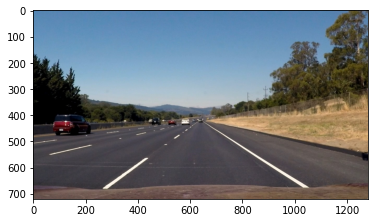

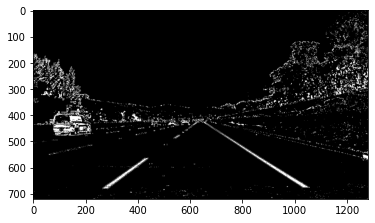

In [4]:
image = plt.imread(r"C:\Users\sande\udacity self drving\CarND-Advanced-Lane-Lines-master\test_images\straight_lines2.jpg")

# CONSTANTS
ksize = 3
thresh=(20, 100)
mag_thresh_min = 30
mag_thresh_max = 100
dir_thresh=(0.7, 1.3)
threshS =(170, 255)

# Apply sobel to the image (Gradient thresholding)
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0,255)):
      
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])] = 1
    
    return binary_output

# Magnitude of the Soble Gradient
def mag_thresh(img, sobel_kernel, mag_thresh_min, mag_thresh_max):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1 ,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0 ,1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2) 
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(gradmag)
    binary_output[((scaled_sobel >= mag_thresh_min) & (scaled_sobel <= mag_thresh_max))] = 1

    return binary_output

# Directional Gradient thresholding
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1 ,0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F,0 ,1, ksize=sobel_kernel)
    grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(grad) 
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    
    return binary_output

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
mag_binary = mag_thresh(image, ksize, 30, 100)
dir_binary = dir_threshold(image, sobel_kernel=5, thresh= dir_thresh)

combined1 = np.zeros_like(dir_binary)
combined1[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Conversion of Color space fomr RGB(Red Green Blue) to HLS(Hue Saturation Brightness) (Colour thresholding)
imageHLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
imageS = imageHLS[:,:,2] 

combined2 = np.zeros_like(imageS)
combined2[(imageS > threshS[0]) & (imageS <= threshS[1])] = 1

# Combining both the thresholding to get the optimum of the categories of thresholding
final_combined = np.zeros_like(imageS)
final_combined[((combined1 == 1) | (combined2==1))]=255 
color_binary = np.dstack(( np.zeros_like(combined2), combined1, combined2))
plt.figure()
plt.imshow(image,cmap="gray")
plt.figure()
plt.imshow(final_combined,cmap="gray")


## Apply Perspective transform to image(Birds eye view) 

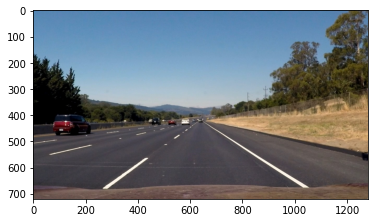

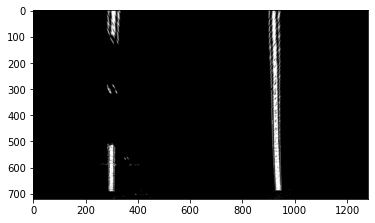

In [5]:
img = np.copy(image) 
length = image.shape[1]
height = image.shape[0]

plt.figure()
plt.imshow(img)

x1, y1 = 220,height
x2, y2 = 550,int(2*height/3)
x3, y3 = length-550,int(2*height/3)
x4, y4 = length - 220,height

# Source and Destination points for non-thransformed image and thransformed image respectively
src=np.float32([[x1,y1], [x2,y2], [x3,y3], [x4,y4]])
dst = np.float32([[300,height], [300,0], [900,0], [900,height]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size=(img.shape[1],img.shape[0])
warped = cv2.warpPerspective(final_combined, M, img_size, flags=cv2.INTER_LINEAR)

# Adding the boundary conditions on the transformed image to remove the unnecessary portion in image
for i in range(250):
    warped[:,i] = 0
for i in range(1000, length):
    warped[:,i] = 0
for i in range(450, 900):
    warped[:,i] = 0    

plt.figure()
plt.imshow(warped, cmap="gray")
# Plotting the line of transformed image
cv2.line(img, (x1,y1), (x2,y2),(255,0,0),2)

cv2.line(img, (x3,y3), (x4,y4),(255,0,0),2)

warpedImg = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)



## Detect lane pixels and fit to find the lane boundary.  

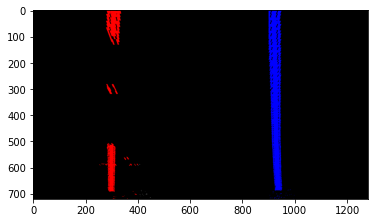

In [6]:
bird_eye_view = np.copy(warped)
def hist(img):
    # Bottom half of the image
    # As lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # Sum across image pixels vertically 
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    return histogram


def find_lane_pixels(binary_warped,frame):
    # Histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.copy(binary_warped)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 9
    # Width of the windows +/- margin
    margin = 100
    M = 100
    # Minimum number of pixels found to recenter window
    minpix = 50

    # Height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    if frame != 0 :
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        if len(nonzerox) > minpix and len(nonzeroy) > minpix:
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                            left_fit[2] - M)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                            left_fit[1]*nonzeroy + left_fit[2] + M)))
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                            right_fit[2] - M)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                            right_fit[1]*nonzeroy + right_fit[2] + M)))
            line_found=1

    
    if frame == 0 or line_found==0:
        # Step through the windows one by one
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        for window in range(nwindows):
            # Identifying window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### Boundaries of the window ###
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin 
            win_xright_low = rightx_current - margin  
            win_xright_high = rightx_current + margin 


            ### Identifying the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
            line_found=1
            frame=1
        ### If found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #v Convert distance from image coordinated to actual real word corredinated in (metres) 
    midpoint = length/2
    ym_per_pix = 30 / 720   # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    line_lt_bottom = np.mean(leftx[lefty > 0.95 * max(lefty)])
    
    line_rt_bottom = np.mean(rightx[righty > 0.95 * max(righty)])
    lane_width = line_rt_bottom - line_lt_bottom
    
    offset_pix = abs((line_lt_bottom + lane_width / 2) - midpoint)
    
    offset = xm_per_pix * offset_pix
    
    return leftx, lefty, rightx, righty, out_img, offset

def fit_polynomial(binary_warped, frame):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, offset = find_lane_pixels(binary_warped, frame)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    #plt.fill_betweenx(ploty, left_fitx, right_fitx, color='green', alpha=0.4 )

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='green')
#     plt.plot(right_fitx, ploty, color='green')

    ym_per_pix = 30 / 720   # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    y_eval = np.max(ploty)*ym_per_pix
    
    
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad_corrected = ((1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5)/abs(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad_corrected = ((1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5)/abs(2*right_fit[0])  ## Implement the calculation of the right line here
    rad_of_curvature = round((left_curverad_corrected+right_curverad_corrected)/2)

    
    
    
        
    
    return out_img, rad_of_curvature, left_fitx, right_fitx, ploty, offset


# Create histogram of image binary activations
histogram = hist(bird_eye_view)
# Visualize the resulting histogram
#plt.plot(histogram)
frame=0
out_img, rad_of_curvature, left_fitx, right_fitx, ploty, offset = fit_polynomial(bird_eye_view, frame)
plt.imshow(out_img)





## Determine the curvature of the lane and vehicle position with respect to center 

In [7]:
rad_of_curvature

5490

## Warp the detected lane boundaries back onto the original image 

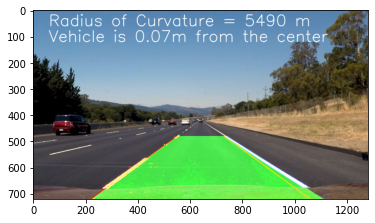

In [8]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 2
color = (255, 255, 255)
thickness = 2
string1 = "Radius of Curvature = " + str(rad_of_curvature) + " m"
string2 = "Vehicle is "+str(np.round(offset,2))+"m from the center" 

for i in range(len(left_fitx)):
    start = int(left_fitx[i])
    end = int(right_fitx[i])
    warped[i,start:end] = 225

R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

unwarpedG = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
unwarped = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_LINEAR)
final_image = np.zeros_like(image)

final_image[:,:,0] = R | unwarped[:,:,0]
final_image[:,:,1] = G | unwarpedG
final_image[:,:,2] = B | unwarped[:,:,2]


final_image = cv2.putText(final_image, string1, (60, 60), font, fontScale, color, thickness, cv2.LINE_AA)
final_image = cv2.putText(final_image, string2, (60, 120), font, fontScale, color, thickness, cv2.LINE_AA)

plt.imshow(final_image)


## Pipeline for lane detection

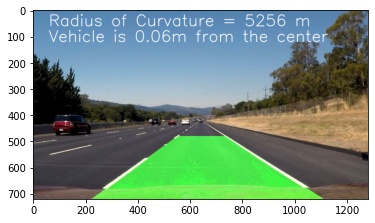

In [9]:
def process_image(image):
    frame=0
    ksize = 3
    thresh=(20, 100)
    mag_thresh_min = 30
    mag_thresh_max = 100
    dir_thresh=(0.7, 1.3)
    threshS =(170, 255)
    #-----------------------------------THRESHOLDING THE IMAGE--------------------------------------------------
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
    mag_binary = mag_thresh(image, ksize, 30, 100)
    dir_binary = dir_threshold(image, sobel_kernel=5, thresh= dir_thresh)

    combined1 = np.zeros_like(dir_binary)
    combined1[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


    imageHLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    imageS = imageHLS[:,:,2] 

    combined2 = np.zeros_like(imageS)
    combined2[(imageS > threshS[0]) & (imageS <= threshS[1])] = 1


    final_combined = np.zeros_like(imageS)
    final_combined[((combined1 == 1) | (combined2==1))]=255 
    color_binary = np.dstack(( np.zeros_like(combined2), combined1, combined2))

    #------------------------------------APPLYING PERSPECTIVE TRANSFORM----------------------------------------
    img = np.copy(image) 
    length = image.shape[1]
    height = image.shape[0]

    x1, y1 = 220,height
    x2, y2 = 550,int(2*height/3)
    x3, y3 = length-550,int(2*height/3)
    x4, y4 = length - 220,height

    src=np.float32([[x1,y1], [x2,y2], [x3,y3], [x4,y4]])
    dst = np.float32([[300,height], [300,0], [900,0], [900,height]])

    M = cv2.getPerspectiveTransform(src, dst)
    img_size=(img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(final_combined, M, img_size, flags=cv2.INTER_LINEAR)
    for i in range(250):
        warped[:,i] = 0
    for i in range(1050, length):
        warped[:,i] = 0
    for i in range(490, 900):
        warped[:,i] = 0  
    #-----------------------------------LANE FINDING AND VISUALIZATION----------------------------------------
    
    bird_eye_view = np.copy(warped)
    histogram = hist(bird_eye_view)


    out_img, rad_of_curvature, left_fitx, right_fitx, ploty, offset= fit_polynomial(bird_eye_view, frame)

    #--------------------------------TRANSFORMING THE IMAGE BACK TO NORMAL-------------------------------------
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    color = (255, 255, 255)
    thickness = 2
    string1 = "Radius of Curvature = " + str(rad_of_curvature) + " m"
    string2 = "Vehicle is "+str(np.round(offset,2))+"m from the center" 

    for i in range(len(left_fitx)):
        start = int(left_fitx[i])
        end = int(right_fitx[i])
        warped[i,start:end] = 225

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    unwarpedG = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_LINEAR)
    final_image = np.zeros_like(image)

    final_image[:,:,0] = R 
    final_image[:,:,1] = G | unwarpedG
    final_image[:,:,2] = B 


    final_image = cv2.putText(final_image, string1, (60, 60), font, fontScale, color, thickness, cv2.LINE_AA)
    final_image = cv2.putText(final_image, string2, (60, 120), font, fontScale, color, thickness, cv2.LINE_AA)

    
    
    return final_image
image = process_image(image)
plt.imshow(image)

In [10]:
white_output = r'C:\Users\sande\udacity self drving\CarND-Advanced-Lane-Lines-master\output_images\project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(r"C:\Users\sande\udacity self drving\CarND-Advanced-Lane-Lines-master\project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)